In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.interpolate import RectBivariateSpline, interp1d
from scipy.integrate import simps

Calculate likelihoods / chisq for a model containing a combination of photo-z uncertainty as a function of a mean shift to the redshift distribution for each source bin ($\Delta z$ A and B) and a single A_IA intrinsic alignment parameter across 1 and 2 halo scales.

Make plots.

In [2]:
# Note the first sigz point is not linearly spaced so should not really be used for plotting atm
#delza = #([-0.2, -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.1, -0.09, -0.08, -0.07, -0.06, 
        #  -0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 
        # 0.07, 0.08]#, 0.09, 0.1])
delza = ([-0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 
        0.07, 0.08])

#delzb = ([-0.3, -0.29, -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21,-0.2, -0.19, -0.18, -0.17, -0.16, 
#          -0.15, -0.14, -0.13, -0.12, -0.11,-0.1, -0.09, -0.08, -0.07, -0.06, 
#          -0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 
#         0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2,  0.21, 0.22, 0.23, 
#          0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4,
#         0.41,0.42,0.43,0.44,0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51,0.52,0.53,0.54,0.55,0.56, 0.57, 0.58, 0.59, 0.6,
#         0.61,0.62,0.63,0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 
#          0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 
#          0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.10, 1.11, 1.12, 1.13, 
#          1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.30, 
#          1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.40, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 
#          1.48, 1.49, 1.50, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.60, 1.61, 1.62, 1.63, 1.64, 
#          1.65, 1.66, 1.67, 1.68, 1.69, 1.70, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.80, 1.81, 
#          1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.90, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 
#          1.99, 2.00])

delzb = ([-0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])

sigz = [0,0]

AIA = ([-0.1, -0.08, -0.06, -0.04, -0.02, 0.0, 0.02, 0.04, 
        0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36])

In [3]:
# Load data vectors for each case and get the signal to noise.
# Load the covariance in order to do this
data_cov = np.load('./txtfiles/DESY1_quantities_fromSara/10KsourceBins_1KlensBins/planck2018_params/CovMat.npy')
inv_data_cov = np.linalg.inv(data_cov)
gamma_IA_fid = np.loadtxt('./txtfiles/DESY1_quantities_fromSara/10KsourceBins_1KlensBins/planck2018_params/GammaIA')
endfile = 'DESY1_wfidIA_measured-redshifts-wrong_variableF_DESHoD'

chisquared = np.zeros((len(delza), len(delzb), len(AIA)))
for ai in range(0,len(AIA)):
    for dia in range(0, len(delza)):
        for dib in range(0,len(delzb)):
            theta, data_vec = np.loadtxt('./txtfiles/photo_z_test/gamma_IA_est_'+endfile+'_sigz=0.0_delzA='+str(delza[dia])+'_delzB='+str(delzb[dib])+'_Aia='+str(AIA[ai])+'.txt', unpack=True)
            diff = data_vec - gamma_IA_fid

            chisquared[dia, dib, ai] = np.dot(diff,np.dot(inv_data_cov,diff))
            
loglike = -0.5*chisquared

OSError: ./txtfiles/photo_z_test/gamma_IA_est_DESY1_wfidIA_measured-redshifts-wrong_variableF_DESHoD_sigz=0.0_delzA=-0.08_delzB=-0.08_Aia=-0.1.txt not found.

In [ ]:
# We want to look at a chi squared distribution with the correct number of degrees of freedom
# And calculate the probability that each of our photo-z uncertainty + A_IA models are drawn from this distribution.

To understand why we are seeing no apparent degeneracy between A_IA and the photo-z parameters, want to pick a relatively high likelihood value and plot each contribution.

In [4]:
min_loglike = np.amax(loglike)
ind_best = np.where(loglike==min_loglike)

In [5]:
# What is the chi squared for this?
DOF = len(gamma_IA_fid) - 2 # Fitting two parameters
bestfit_chi2 = chisquared[ind_best[0][0], ind_best[1][0], ind_best[2][0]]
bestfit_chi2_dof = bestfit_chi2/DOF

print('chi^2 / DOF at best fit=', bestfit_chi2_dof)

chi^2 / DOF at best fit= 0.47136086497732865


In [6]:
# Print the max likelihood values:
print('Max likelihood is at Delta z a=', delza[ind_best[0][0]], 'Delta z b=', delzb[ind_best[1][0]], 'AIA=', AIA[ind_best[2][0]])

Max likelihood is at Delta z a= -0.07 Delta z b= 0.07 AIA= 0.12


In [5]:
# The lensing contribution will be given by the gamma_IA with these pz parameters and AIA=0.
# And vice-versa for AIA:

theta_1, AIA_contr_bestfit = np.loadtxt('./txtfiles/photo_z_test/gamma_IA_est_'+endfile+'_sigz=0.0_delzA=0_delzB=0_Aia=0.12.txt', unpack=True)
theta_2, pz_contr_bestfit = np.loadtxt('./txtfiles/photo_z_test/gamma_IA_est_'+endfile+'_sigz=0.0_delzA=-0.07_delzB=0.07_Aia=0.0.txt', unpack=True)

OSError: ./txtfiles/photo_z_test/gamma_IA_est_DESY1_wfidIA_measured-redshifts-wrong_variableF_DESHoD_sigz=0.0_delzA=0_delzB=0_Aia=0.12.txt not found.

In [6]:
# Jonathan's model contribution:
theta_3, gam_mod = np.loadtxt('./txtfiles/photo_z_test/mod_IA_nfw_plus_lin.txt', unpack=True)
AIA_Jon = 0.12*gam_mod

In [9]:
theta_4, finite_lens_contr = np.loadtxt('./txtfiles/photo_z_test/gamma_IA_est_'+endfile+'_sigz=0.0_delzA=0_delzB=0_Aia=0.0.txt', unpack=True)

In [10]:
# Load the lensing-only gamma_t to see if it has the right scale-dependence before dividing B-1+F
theta_5, gammat_a_lens = np.loadtxt('./txtfiles/photo_z_test/gammat_lens_A_'+endfile+'.dat', unpack=True)
theta_6, gammat_b_lens = np.loadtxt('./txtfiles/photo_z_test/gammat_lens_B_'+endfile+'.dat', unpack=True)

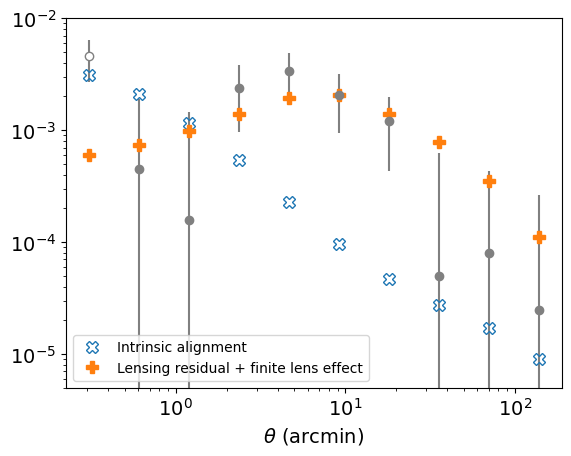

In [11]:
plt.figure()
plt.errorbar(theta_1, gamma_IA_fid, yerr = np.sqrt(np.diag(data_cov)), marker='o',markersize=6,linestyle='',color='#808080')
plt.errorbar([theta_1[0]], [-gamma_IA_fid[0]], yerr = [np.sqrt(np.diag(data_cov))[0]], color='#808080',marker='o',mfc='w')
plt.loglog(theta_1, -AIA_Jon, marker='X',  markersize=8, fillstyle='none',linestyle='',label='Intrinsic alignment')
#plt.loglog(theta_2, -AIA_contr_bestfit, marker='X',  markersize=8,linestyle='',color='#6495ED', fillstyle='none')
#plt.loglog(theta_3, -AIA_Jon, color='#6495ED', label='IA only, direct modelling from Jonathan (neg)')
plt.loglog(theta_2, pz_contr_bestfit, 'P', markersize=8,label='Lensing residual + finite lens effect')
#plt.loglog(theta_2, AIA_contr_bestfit+pz_contr_bestfit, 'o', color='m', label='full best fit')
#plt.loglog(theta_2, -(AIA_contr_bestfit+pz_contr_bestfit), 'o', color='m', mfc='w')
#plt.loglog(theta_4, AIA_Jon+finite_lens_contr, '+',color='m',markersize=16,label='IA model + finite lens width')
#plt.loglog(theta_4, -1.0*(AIA_Jon+finite_lens_contr),'x',color='m', markersize=16, label='IA model + finite lens width (neg)')
#plt.loglog(theta_5, gammat_a_lens, 'k', linestyle='--', label='lensing only, A')
#plt.loglog(theta_6, gammat_b_lens, 'k',linestyle=':', label='lensing only, B')
plt.ylim(5*10**(-6), 10**(-2))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.title('$A_{IA}=0.12$, $\Delta z_A = -0.04$, $\Delta z_b =1.2$')
plt.xlabel('$\\theta$ (arcmin)', fontsize=14)
#ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(loc='lower left')
#plt.savefig('./compare_terms_best_fit_AIA=0.12_DeltazA=-0.08_DeltazB=0.08.pdf')
plt.show()

Now make a version of this plot where the Delta z A and B contributions are at values more comparable to the best-fit values of DES Y1 for comparable source bins, so show we still fit well in that case.

Our bin A is 0.3-0.45, whilst their bin 1 is 0.2-0.43. Their posterior best-fit shift for this bin is: $0.001 \pm 1.3$. 

Our bin B is 0.55-0.7. Their bin 2 is 0.43-0.63 and bin 3 is 0.63-0.90. Their posterior best-fit for bin 2 is $-0.02(+0.011)(-0.9)$, and bin 3 if $0.009(+0.008)(-0.009)$.

So for bin A if we pick 0.0 and bin B if we pick -0.02:

In [ ]:
theta_DESY1, pz_contr_DESY1bestfit = np.loadtxt('./txtfiles/photo_z_test/gamma_IA_est_'+endfile+'_sigz=0.0_delzA=-0.01_delzB=0.01_Aia=0.0.txt', unpack=True)

In [ ]:
plt.figure()
plt.errorbar(theta_1, gamma_IA_fid, yerr = np.sqrt(np.diag(data_cov)), marker='o',markersize=6,linestyle='',color='#808080')
plt.errorbar([theta_1[0]], [-gamma_IA_fid[0]], yerr = [np.sqrt(np.diag(data_cov))[0]], color='#808080',marker='o',mfc='w')
plt.loglog(theta_1, -AIA_Jon, marker='X',  markersize=8, fillstyle='none',linestyle='',label='Intrinsic alignment')
#plt.loglog(theta_2, -AIA_contr_bestfit, marker='X',  markersize=8,linestyle='',color='#6495ED', fillstyle='none')
#plt.loglog(theta_3, -AIA_Jon, color='#6495ED', label='IA only, direct modelling from Jonathan (neg)')
plt.loglog(theta_DESY1, pz_contr_DESY1bestfit, 'P', markersize=8,label='Lensing residual + finite lens effect')
#plt.loglog(theta_2, AIA_contr_bestfit+pz_contr_bestfit, 'o', color='m', label='full best fit')
#plt.loglog(theta_2, -(AIA_contr_bestfit+pz_contr_bestfit), 'o', color='m', mfc='w')
#plt.loglog(theta_4, AIA_Jon+finite_lens_contr, '+',color='m',markersize=16,label='IA model + finite lens width')
#plt.loglog(theta_4, -1.0*(AIA_Jon+finite_lens_contr),'x',color='m', markersize=16, label='IA model + finite lens width (neg)')
#plt.loglog(theta_5, gammat_a_lens, 'k', linestyle='--', label='lensing only, A')
#plt.loglog(theta_6, gammat_b_lens, 'k',linestyle=':', label='lensing only, B')
plt.ylim(5*10**(-6), 10**(-2))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.title('$A_{IA}=0.12$, $\Delta z_A = -0.04$, $\Delta z_b =1.2$')
plt.xlabel('$\\theta$ (arcmin)', fontsize=14)
#ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(loc='lower left')
#plt.savefig('./compare_terms_best_fit_AIA=0.12_DeltazA=-0.01_DeltazB=0.01.pdf')
plt.show()

In [ ]:
chisq_DESY1_bestfit = chisquared[11, 7, 9]
chisqu_DESY1_bestfit_DOF = chisq_DESY1_bestfit/DOF
print(chisqu_DESY1_bestfit_DOF)

Look at the difference between the Boost as measured vs modelled just to make sure it's okay?

In [42]:
Boost_A_measured = np.loadtxt('./txtfiles/results_sara/Fiducial/AvgBoost0')
Boost_A_modelled = np.loadtxt('./txtfiles/boosts/Boost_A_survey=DESY1_DESHoD.txt') + np.ones((len(Boost_A_measured)))

Boost_B_measured = np.loadtxt('./txtfiles/results_sara/Fiducial/AvgBoost1')
Boost_B_modelled = np.loadtxt('./txtfiles/boosts/Boost_B_survey=DESY1_DESHoD.txt') + np.ones((len(Boost_B_measured)))

F_A_measured = np.loadtxt('./txtfiles/results_sara/Fiducial/AvgF0')
F_B_measured = np.loadtxt('./txtfiles/results_sara/Fiducial/AvgF1')

DeltaSigma = np.loadtxt('./txtfiles/DeltaSigma_with1halo_DESHoD.txt')

In [52]:
zL = np.loadtxt('./txtfiles/z_list_DESY1.txt')
DeltaSigma_centbins = np.zeros((len(theta_radians), len(zL)))
for zi in 0:
    print("Delta_Sig_theory, zi=", zL[zi])
    zload=str('{:1.12f}'.format(zL[zi]))
    # Import the appropriate correlation function
    r_hf, corr_hf_2h = np.loadtxt('./txtfiles/halofit_xi/xi2h_z='+zload+'_DESHoD.txt', unpack=True)
    r_hf, corr_1h = np.loadtxt('./txtfiles/xi_1h_terms/xi1h_ls_z='+zload+'_DESHoD.txt', unpack=True)
    for ri in range(0,len(r_hf)):
        if r_hf[ri]>3:
            corr_1h[ri] = 0.
    corr_hf = corr_hf_2h + corr_1h

plt.figure()
plt.loglog(r_hf, corr_hf)
plt.show()

FileNotFoundError: ./txtfiles/z_list_DESY1.txt not found.

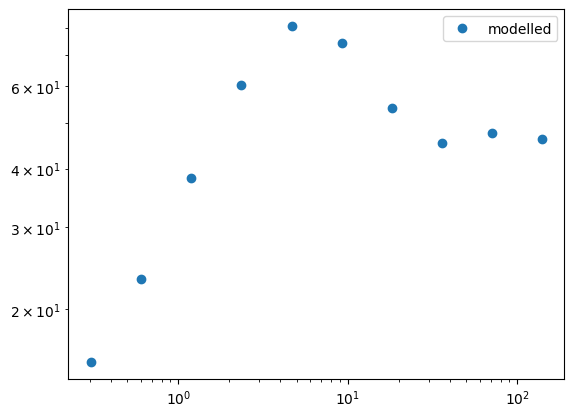

In [51]:
plt.figure()
plt.loglog(theta_1, DeltaSigma[:,10]/ (Boost_A_measured-1), 'o',label='modelled')
#plt.loglog(theta_1, Boost_A_modelled - 1.0, 'o', label='modelled')
plt.legend()
plt.show()

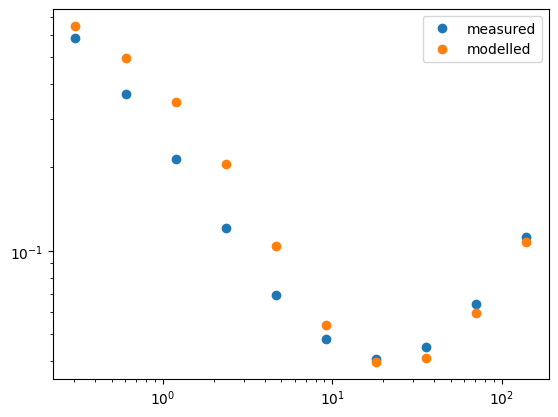

In [44]:
plt.figure()
plt.loglog(theta_1, Boost_A_measured - 1.0+F_A_measured, 'o',label='measured')
plt.loglog(theta_1, Boost_A_modelled - 1.0+F_A_measured, 'o', label='modelled')
plt.legend()
plt.show()

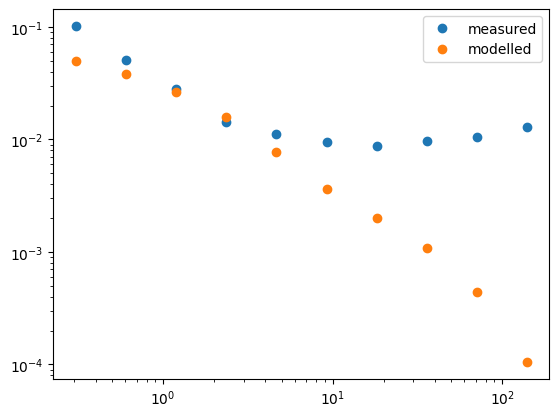

In [47]:
plt.figure()
plt.loglog(theta_1, Boost_B_measured - 1.0+F_B_measured, 'o', label='measured')
plt.loglog(theta_1, Boost_B_modelled - 1.0, 'o', label='modelled')
plt.legend()
plt.show()

Is the massively increased sensitivity to Delta z A over Delta z B just because if we go positive on Delta z B we are not in the regime where we are shifting into overlap with the lenses therefore triggering zero-ing of Sigma Crit?

In [ ]:
theta_full, full_best_fit = np.loadtxt('./txtfiles/photo_z_test/gamma_IA_est_'+endfile+'_sigz=0.0_delzA=-0.07_delzB=0.29_Aia=0.12.txt', unpack=True)

In [ ]:
np.diag(data_cov)#data_cov.shape

In [ ]:
plt.figure()
plt.loglog(theta_full, full_best_fit, 'o', label='Best fit model (+ve)')
plt.loglog(theta_full, -full_best_fit, 'o', label='Best fit model (-ve)')
plt.errorbar(theta_full, gamma_IA_fid, yerr= np.sqrt(np.diag(data_cov)), fmt='o',label='Data, (+ve)')
plt.errorbar([theta_full[0]], [-gamma_IA_fid[0]], yerr= np.sqrt(np.diag(data_cov))[0], fmt='o',label='Data, (-ve)')
plt.ylim(10**(-7), 10**(-2))
plt.yscale('log')
plt.title('$A_{IA}=0.12$, $\Delta z_A = -0.07$, $\Delta z_A =0.29$')
plt.xlabel('$\\theta$ (arcmin)')
plt.legend()
#plt.savefig('./compare_terms.pdf')
plt.show()

Okay, but what we would really like is a classic 'triangle plot' for the 3 parameters with marginalisation in each 2D plane over the not-shown parameter (and maybe 1D plots over both parameters not shown). Let us construct this. We follow the maths for this from the postprocess module of cosmosis.

In [12]:
# Get 2D marginalised distributions

# First normalise the log likelihood such that its peak value is 0
loglike_norm = loglike - np.amax(loglike)

# Now sum over the extra parameter in each 2D case. 
# This only works mathematically if you have sampled out to the edges of the distribution.

loglike_dza_dzb = np.zeros((len(delza), len(delzb)))
for zia in range(0,len(delza)):
    for zib in range(0,len(delzb)):
        loglike_dza_dzb[zia,zib] = np.log(np.sum(np.exp(loglike_norm[zia, zib,:])))
loglike_dza_dzb_norm = loglike_dza_dzb - np.amax(loglike_dza_dzb)
like_dza_dzb_norm = np.exp(loglike_dza_dzb_norm)

loglike_dza_aia = np.zeros((len(delza), len(AIA)))
for zi in range(0,len(delza)):
    for ai in range(0,len(AIA)):
        loglike_dza_aia[zi,ai] = np.log(np.sum(np.exp(loglike_norm[zi,:, ai])))
loglike_dza_aia_norm = loglike_dza_aia - np.amax(loglike_dza_aia)
like_dza_aia_norm = np.exp(loglike_dza_aia_norm)

loglike_dzb_aia = np.zeros((len(delzb), len(AIA)))
for zib in range(0,len(delzb)):
    for ai in range(0,len(AIA)):
        loglike_dzb_aia[zib,ai] = np.log(np.sum(np.exp(loglike_norm[:,zib, ai])))
loglike_dzb_aia_norm = loglike_dzb_aia - np.amax(loglike_dzb_aia)
like_dzb_aia_norm = np.exp(loglike_dzb_aia_norm)


In [13]:
# Now also get the 1_D dist for each.
# This only works mathematically if you have sampled out to the edges of the distribution.

loglike_dza = np.zeros((len(delza)))
for di in range(0,len(delza)):
    loglike_dza[di] = np.log(np.sum(np.exp(loglike_dza_aia_norm[di,:])))
loglike_dza_norm = loglike_dza - np.amax(loglike_dza)
like_dza = np.exp(loglike_dza_norm)

loglike_dzb = np.zeros((len(delzb)))
for di in range(0,len(delzb)):
    loglike_dzb[di] = np.log(np.sum(np.exp(loglike_dzb_aia_norm[di,:])))
loglike_dzb_norm = loglike_dzb - np.amax(loglike_dzb)
like_dzb = np.exp(loglike_dzb_norm)

loglike_AIA = np.zeros((len(AIA)))
for ai in range(0,len(AIA)):
    loglike_AIA[ai] = np.log(np.sum(np.exp(loglike_dza_aia_norm[:,ai])))
loglike_AIA_norm = loglike_AIA - np.amax(loglike_AIA)
like_AIA = np.exp(loglike_AIA_norm)

#loglike_dz_aia = np.zeros((len(delz), len(AIA)))
#for zi in range(0,len(delz)):
#    for ai in range(0,len(AIA)):
#        loglike_dz_aia[zi,ai] = np.log(np.sum(np.exp(loglike_norm[zi,:, ai])))
#loglike_dz_aia_norm = loglike_dz_aia - np.amax(loglike_dz_aia)
#like_dz_aia_norm = np.exp(loglike_dz_aia_norm)

#loglike_sigz_aia = np.zeros((len(sigz), len(AIA)))
#for si in range(0,len(sigz)):
#    for ai in range(0,len(AIA)):
#        loglike_sigz_aia[si,ai] = np.log(np.sum(np.exp(loglike_norm[:,si, ai])))
#loglike_sigz_aia_norm = loglike_sigz_aia - np.amax(loglike_sigz_aia)
#like_sigz_aia_norm = np.exp(loglike_sigz_aia_norm)

In [14]:
max_like = np.amax(like_AIA)
ind_best = np.where(like_AIA==max_like)

In [ ]:
max_AIA

/tmp/ipykernel_2208475/3579670337.py:31: UserWarning: The following kwargs were not used by contour: 'aspect'
  axs[2,1].contour(delza, delzb, like_dza_dzb_norm.T, [0.68,0.95], aspect=0.9,linestyles=['solid','dashed'],colors='k', linewidths=1)
/tmp/ipykernel_2208475/3579670337.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


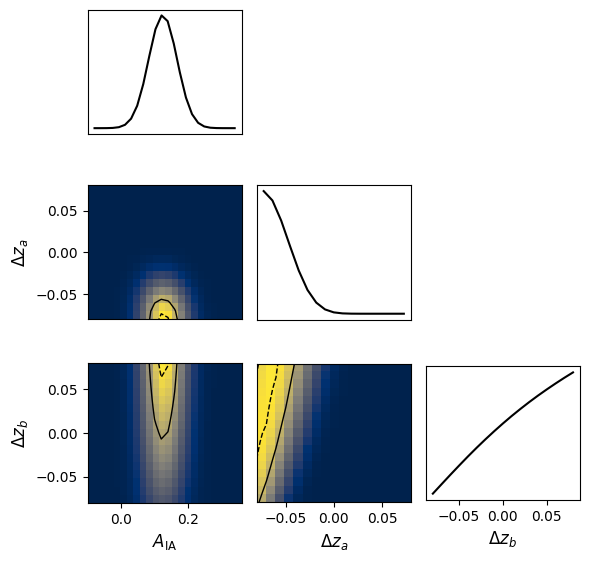

In [15]:
colorbar_info = plt.cm.ScalarMappable(cmap='cividis')
# Now make these into a triangle plot
fig, axs = plt.subplots(3, 3,figsize=[6,6], layout="constrained")
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])
axs[0,0].plot(AIA, like_AIA, color='k')
axs[0,0].set_yticks([])
axs[0,0].set_xticks([])
axs[1,0].set_xticks([])
axs[1,1].set_xticks([])
axs[0,0].set_aspect(0.37)
axs[0,0].tick_params(labelsize=10)
axs[1, 0].imshow(like_dza_aia_norm, origin='lower', extent = [-0.1,0.36, -0.08, 0.08], aspect=2.5, cmap='cividis')
#axs[0,0].set_xlabel('$AIA$', fontsize=16)
axs[1,0].set_ylabel('$\Delta z_a$', fontsize=12)
axs[1,0].contour(AIA,delza,  like_dza_aia_norm, [0.68,0.95], linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[1,0].tick_params(labelsize=10)
axs[1,1].plot(delza, like_dza, color='k')
axs[1,1].set_yticks([])
axs[1,1].set_aspect(0.14)
axs[1,1].tick_params(labelsize=10)
axs[2, 0].imshow(like_dzb_aia_norm, origin='lower',extent = [-0.1,0.36,-0.08, 0.08], aspect=2.6, cmap='cividis')
axs[2,0].set_xlabel('$A_{\\rm IA}$', fontsize=12)
axs[2,0].set_ylabel('$\Delta z_b$', fontsize=12)
axs[2,0].contour(AIA,delzb,  like_dzb_aia_norm, [0.68,0.95], linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[2,0].tick_params(labelsize=10)
axs[2,1].imshow(like_dza_dzb_norm.T, extent = [-0.08, 0.08, -0.08, 0.08], origin='lower', aspect=0.9,cmap='cividis')
axs[2,1].set_xlabel('$\Delta z_a$', fontsize=12)
#axs[1,1].set_ylabel('$\Delta z$', fontsize=16)
axs[2,1].contour(delza, delzb, like_dza_dzb_norm.T, [0.68,0.95], aspect=0.9,linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[2,1].tick_params(labelsize=10)
axs[2,1].set_yticks([])
axs[2,2].plot(delzb, like_dzb, color='k')
axs[2,2].set_yticks([])
axs[2,2].set_aspect(0.2)
axs[2,2].set_xlabel('$\Delta z_b $', fontsize=12)
axs[1,1].tick_params(labelsize=10)
#plt.constrained_layout('True')
plt.tight_layout()
#plt.savefig('./triangle_plot_full_distributions_priors_dza_dzb.pdf')
plt.show()


In [16]:
# Interpolate to get smoothe contours

# 2D

plot_dzb_ai = like_dzb_aia_norm
dzb_ai_spline = RectBivariateSpline(delzb, AIA, plot_dzb_ai)

dzb_plot = np.linspace(-0.08,0.08, 100)
AIA_plot = np.linspace(-0.1,0.36, 100)
dzb_ai_smooth = np.zeros((len(dzb_plot), len(AIA_plot)))
for si in range(0,len(dzb_plot)):
    for ai in range(0,len(AIA_plot)):
        dzb_ai_smooth[si,ai] = dzb_ai_spline.ev(dzb_plot[si], AIA_plot[ai])

plot_dza_ai =like_dza_aia_norm
dza_ai_spline = RectBivariateSpline(delza, AIA, plot_dza_ai)

delza_plot = np.linspace(-0.08, 0.08, 100)
delza_ai_smooth = np.zeros((len(delza_plot), len(AIA_plot)))
for di in range(0,len(delza_plot)):
    for ai in range(0,len(AIA_plot)):
        delza_ai_smooth[di,ai] = dza_ai_spline.ev(delza_plot[di], AIA_plot[ai])

plot_dza_dzb =like_dza_dzb_norm
dza_dzb_spline = RectBivariateSpline(delza, delzb, plot_dza_dzb)

dza_dzb_smooth = np.zeros((len(delza_plot), len(dzb_plot)))
for di in range(0,len(delza_plot)):
    for si in range(0,len(dzb_plot)):
        dza_dzb_smooth[di,si] = dza_dzb_spline.ev(delza_plot[di], dzb_plot[si])

In [17]:
# 1D:

delza_spline = interp1d(delza, like_dza)
delza_smooth = delza_spline(delza_plot)

ai_spline = interp1d(AIA, like_AIA)
ai_smooth = ai_spline(AIA_plot)

dzb_spline = interp1d(delzb, like_dzb)
dzb_smooth = dzb_spline(dzb_plot)

In [18]:
# Get the marginalised constraint on AIA:sigz
likeaia_norm = ai_smooth / simps(ai_smooth, AIA_plot)

max_like = np.amax(likeaia_norm)
ind_best = np.where(likeaia_norm==max_like)

print(ind_best[0])

AIA_plot[ind_best[0][0]]

[48]


0.12303030303030302

In [19]:
for i in range(ind_best[0][0]+1,len(AIA_plot)):
    int_val = simps(likeaia_norm[ind_best[0][0]:i],AIA_plot[ind_best[0][0]:i])
    #print(int_val)
    if int_val>=0.341:
        pluserror = AIA_plot[i]-AIA_plot[ind_best[0][0]]
        print('upper error=', pluserror)
        break

upper error= 0.05575757575757573


In [20]:
for i in range(ind_best[0][0]-1,0, -1):
    int_val = simps(likeaia_norm[i:ind_best[0][0]],AIA_plot[i:ind_best[0][0]])
    #print(int_val)
    if int_val>=0.341:
        minuserror = AIA_plot[ind_best[0][0]]-AIA_plot[i]
        print('minus error=', minuserror)
        break

minus error= 0.060404040404040404


In [21]:
ind_best

(array([48]),)

In [22]:
sigz_ai_smooth.shape

NameError: name 'sigz_ai_smooth' is not defined

/tmp/ipykernel_2208475/3331848469.py:31: UserWarning: The following kwargs were not used by contour: 'aspect'
  axs[2,1].contour(delza_plot, dzb_plot, dza_dzb_smooth.T, [0.68,0.95], aspect=0.9,linestyles=['solid','dashed'],colors='k', linewidths=1)
/tmp/ipykernel_2208475/3331848469.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


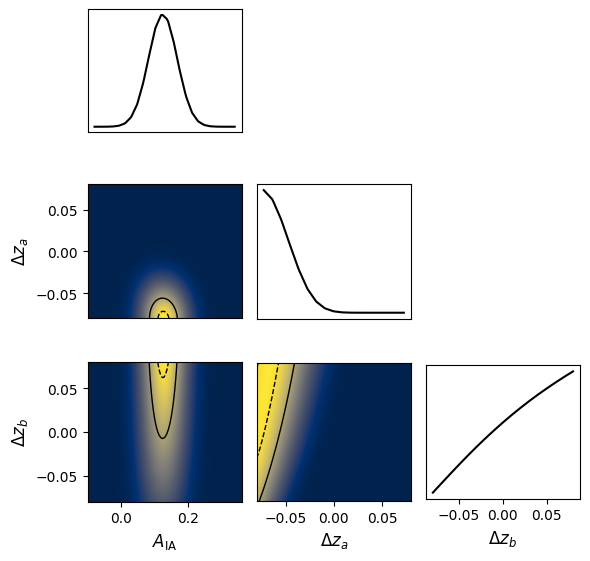

In [23]:
colorbar_info = plt.cm.ScalarMappable(cmap='cividis')
# Now make these into a triangle plot
fig, axs = plt.subplots(3, 3,figsize=[6,6], layout="constrained")
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])
axs[0,0].plot(AIA_plot, ai_smooth, color='k')
axs[0,0].set_yticks([])
axs[0,0].set_xticks([])
axs[1,0].set_xticks([])
axs[1,1].set_xticks([])
axs[0,0].set_aspect(0.37)
axs[0,0].tick_params(labelsize=10)
axs[1, 0].imshow(delza_ai_smooth, origin='lower', extent = [-0.1,0.36, -0.08, 0.08], aspect=2.5, cmap='cividis')
#axs[0,0].set_xlabel('$AIA$', fontsize=16)
axs[1,0].set_ylabel('$\Delta z_a$', fontsize=12)
axs[1,0].contour(AIA_plot,delza_plot, delza_ai_smooth , [0.68,0.95], linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[1,0].tick_params(labelsize=10)
axs[1,1].plot(delza_plot, delza_smooth, color='k')
axs[1,1].set_yticks([])
axs[1,1].set_aspect(0.14)
axs[1,1].tick_params(labelsize=10)
axs[2, 0].imshow(dzb_ai_smooth, origin='lower',extent = [-0.1,0.36,-0.08, 0.08], aspect=2.6, cmap='cividis')
axs[2,0].set_xlabel('$A_{\\rm IA}$', fontsize=12)
axs[2,0].set_ylabel('$\Delta z_b$', fontsize=12)
axs[2,0].contour(AIA_plot,dzb_plot,  dzb_ai_smooth, [0.68,0.95], linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[2,0].tick_params(labelsize=10)
axs[2,1].imshow(dza_dzb_smooth.T, extent = [-0.08, 0.08, -0.08, 0.08], origin='lower', aspect=0.9,cmap='cividis')
axs[2,1].set_xlabel('$\Delta z_a$', fontsize=12)
#axs[1,1].set_ylabel('$\Delta z$', fontsize=16)
axs[2,1].contour(delza_plot, dzb_plot, dza_dzb_smooth.T, [0.68,0.95], aspect=0.9,linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[2,1].tick_params(labelsize=10)
axs[2,1].set_yticks([])
axs[2,2].plot(dzb_plot, dzb_smooth, color='k')
axs[2,2].set_yticks([])
axs[2,2].set_aspect(0.2)
axs[2,2].set_xlabel('$\Delta z_b $', fontsize=12)
axs[1,1].tick_params(labelsize=10)
#plt.constrained_layout('True')
plt.tight_layout()
plt.savefig('./triangle_plot_smoothed_priors_dza_dzb.pdf')
#plt.show()


In [ ]:
colorbar_info = plt.cm.ScalarMappable(cmap='cividis')
# Now actually make these into a triangle plot
fig, axs = plt.subplots(3, 3,figsize=[6,6], layout="constrained")
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])
axs[0,0].plot(AIA_plot, ai_smooth, color='k')
axs[0,0].set_yticks([])
axs[0,0].set_aspect(0.2)
axs[0,0].tick_params(labelsize=10)
axs[1,0].imshow(sigz_ai_smooth, origin='lower', extent = [0.0, 0.2, 0.0,0.05], aspect=4.0, cmap='cividis')#, interpolation='spline36')
axs[1,0].set_ylabel('$\sigma_z$', fontsize=16)
axs[1,0].contour(AIA_plot,sigz_plot, sigz_ai_smooth, [0.68,0.95], linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[1,0].tick_params(labelsize=10)
axs[1,1].plot(sigz_plot_1D, sigz_smooth, color='k')
axs[1,1].set_yticks([])
axs[1,1].set_aspect(0.05/0.4)
axs[1,1].tick_params(labelsize=10)
axs[2, 0].imshow(delz_ai_smooth, origin='lower',extent = [0.0,0.2,0.0, 0.3], aspect=0.66667, cmap='cividis',  interpolation='spline36')
axs[2,0].set_xlabel('$A_{\\rm IA}$', fontsize=12)
axs[2,0].set_ylabel('$\Delta z$', fontsize=12)
axs[2,0].contour(AIA_plot,delz_plot, delz_ai_smooth, [0.68,0.95], linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[2,0].tick_params(labelsize=10)
axs[2,1].imshow(delz_sigz_smooth, extent = [0,0.05,0.0,0.3], origin='lower', aspect=5./30., cmap='cividis', interpolation='spline36')
axs[2,1].set_xlabel('$\sigma_z$', fontsize=12)
#axs[1,1].set_ylabel('$\Delta z$', fontsize=16)
axs[2,1].contour(sigz_plot,delz_plot,  delz_sigz_smooth, [0.68,0.95], linestyles=['solid','dashed'],colors='k', linewidths=1)
axs[2,1].tick_params(labelsize=10)
axs[2,2].plot(delz_plot, delz_smooth, color='k')
#axs[2,2].set_yticks([])
axs[2,2].set_aspect(0.3)
axs[2,2].set_xlabel('$\Delta z$', fontsize=12)
#plt.tight_layout()
plt.savefig('./triangle_plot_cutout_smoothed.pdf')

In [ ]:
(52+55)/2.

In [ ]:
like_dz_aia_norm[-1,:]

In [ ]:
like_dz_sigz_norm[10,:]